# qMRI Synthesis

This notebook is related to MRI synthesis, except that instead of using
a generic contrast model, we use a physics-based forward model. This
allows other types of artefacts to be included (for example, inhomogeneity
of the excitation field, which acts on the intensity in a nonlinear way).
However, the range of parameters that yield a "useful" contrast is much
narrower. Depending on the application, it may therefore be useful to
train using both "nonphysical" and "physical" random contrasts.

In [1]:
!pushd $TMPDIR \
    && wget https://github.com/BBillot/SynthSeg/raw/master/data/training_label_maps/training_seg_01.nii.gz \
    -O demo.nii.gz \
    && popd

--2023-06-12 18:14:36--  https://github.com/BBillot/SynthSeg/raw/master/data/training_label_maps/training_seg_01.nii.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BBillot/SynthSeg/master/data/training_label_maps/training_seg_01.nii.gz [following]
--2023-06-12 18:14:36--  https://raw.githubusercontent.com/BBillot/SynthSeg/master/data/training_label_maps/training_seg_01.nii.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1662924 (1.6M) [application/octet-stream]
Saving to: ‘demo.nii.gz’

demo.nii.gz         100%[===================>]   1.58M  1.92MB/s    in 0.8s    

2023-06-12 18:14:37 (1

In [2]:
import torch
import os
import matplotlib.pyplot as plt
from cornucopia import (
    LoadTransform, RelabelTransform, RandomGMMGradientEchoTransform,
    IntensityTransform, QuantileTransform, MakeAffinePair, RandomAffineElasticTransform,
    RandomAffineTransform,
)

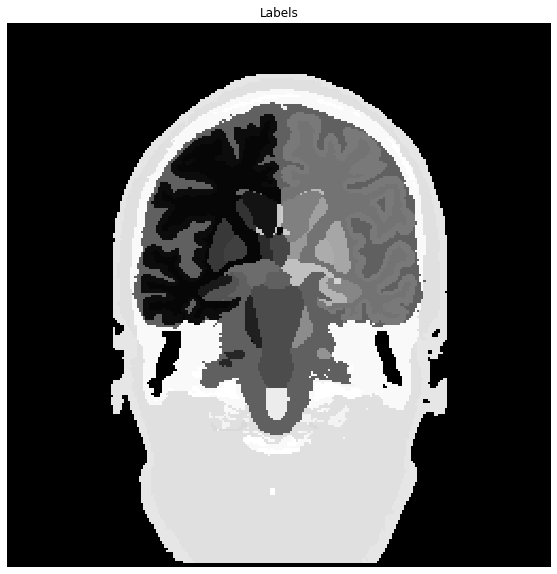

In [3]:
fname = os.path.join(os.environ['TMPDIR'], 'demo.nii.gz')
lab = LoadTransform(dtype=torch.int)(fname)
lab = lab[:, :, lab.shape[-2]//2, :]
lab = RelabelTransform()(lab)

plt.figure(figsize=(10, 10))
plt.imshow(lab[0].T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Labels')
plt.show()

Then, instantiate a `IntensityTransform` and apply it to our labels.
Note that tensors fed to a `Transform` layer should have a channel dimension, and no batch dimension.

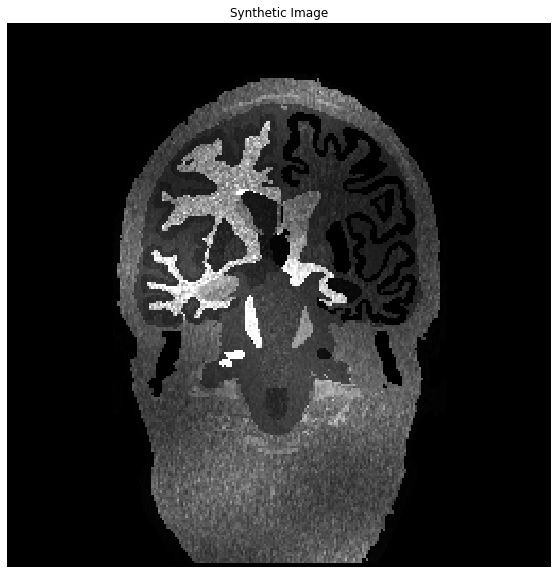

In [4]:
trf = RandomGMMGradientEchoTransform() + QuantileTransform()

img = trf(lab)

plt.figure(figsize=(10, 10))
plt.imshow(img.squeeze().T.flip(0), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.axis('off')
plt.title('Synthetic Image')
plt.show()

Now, let's synthesize a bunch of them

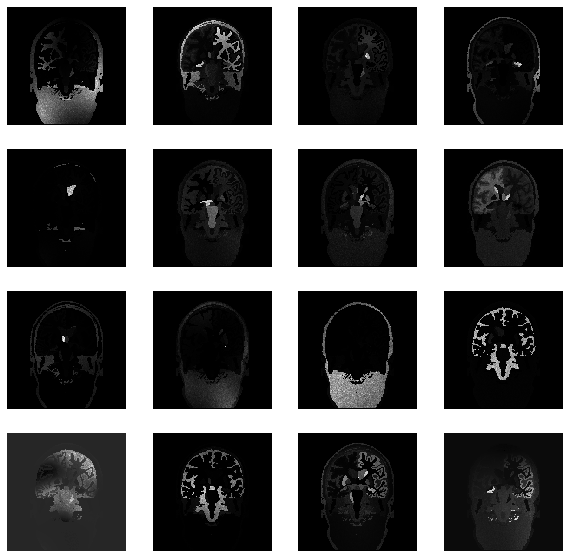

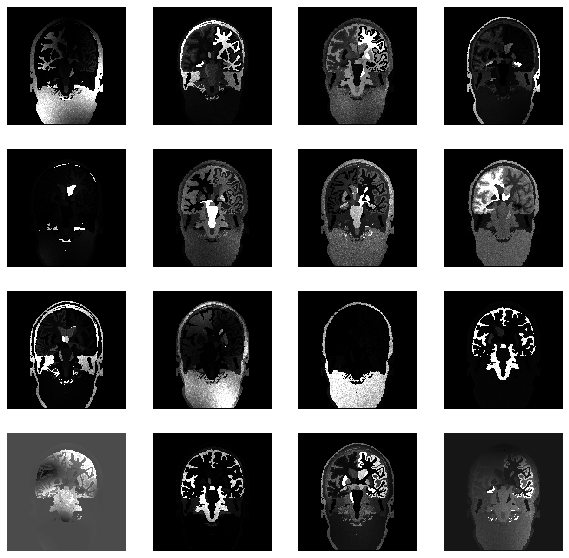

In [5]:
shape = [4, 4]
imgs = []

plt.figure(figsize=(10, 10))
for i in range(shape[0] * shape[1]):
    plt.subplot(*shape, i+1)
    imgs.append(trf(lab))
    plt.imshow(imgs[-1].squeeze().T.flip(0), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()


plt.figure(figsize=(10, 10))
for i in range(shape[0] * shape[1]):
    plt.subplot(*shape, i+1)
    plt.imshow(imgs[i].squeeze().T.flip(0), cmap='gray', interpolation='nearest', vmax=0.8)
    plt.axis('off')
plt.show()

Finally, let's try the full pipeline with deformations

{}


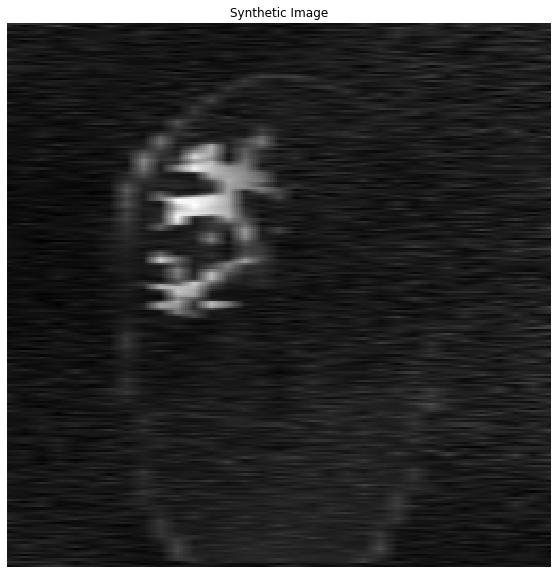

In [6]:
trf = RandomGMMGradientEchoTransform() + QuantileTransform() + IntensityTransform()
img = trf(lab)

plt.figure(figsize=(10, 10))
plt.imshow(img.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Synthetic Image')
plt.show()

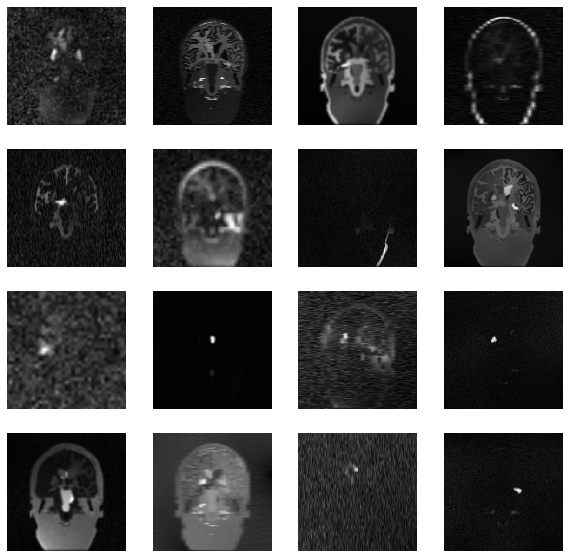

In [7]:
shape = [4, 4]
plt.figure(figsize=(10, 10))

for i in range(shape[0] * shape[1]):
    plt.subplot(*shape, i+1)
    img = trf(lab)
    plt.imshow(img.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()


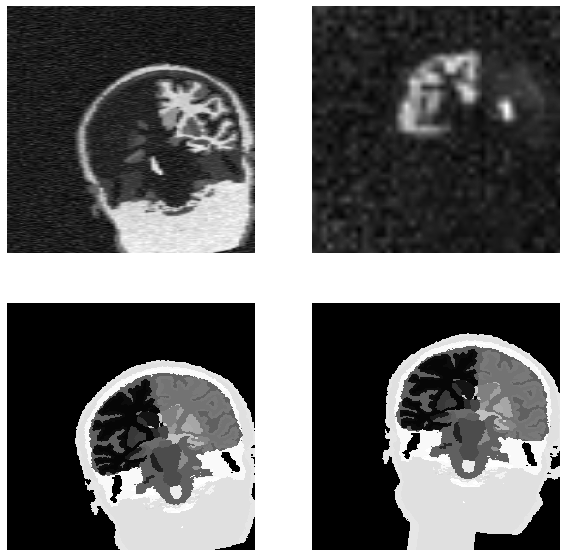

In [11]:
trf = (
        RandomAffineElasticTransform() +
        MakeAffinePair(RandomAffineTransform(shears=0, zooms=0),
                       returns=dict(left='left', right='right', flow='flow')) +
        RandomGMMGradientEchoTransform(returns=dict(label='input', image='output'), append=True, exclude='flow') +
        QuantileTransform(include=['left_image', 'right_image']) +
        IntensityTransform(include=['left_image', 'right_image'])
)

out = trf(lab)
image_left = out['left_image']
image_right = out['right_image']
label_left = out['left_label']
label_right = out['right_label']
flow = out['flow']

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_left.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(image_right.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(label_left.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(label_right.squeeze().T.flip(0), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()
